In [1]:
import pandas as pd
import socnet as sn
import json
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

fp = open('network_cleaned_data.json', 'r')
players = json.load(fp)

In [2]:
print(len(players))

238


In [3]:
def create_gml():
    gml = open("players.gml", "w")
    gml.write("graph [\n  directed 1\n  weighted 1\n")
    for player in players:
        gml.write('  node [\n    id {}\n    label "{}"\n  ]\n'.format(player, str(player)))
    for player in players:
        for team_mate, times_played in players[player]["team_mates"].items():
            gml.write("  edge [\n    source {}\n    target {}\n    weight {}\n  ]\n".format(player, team_mate, times_played))
    gml.write("]")
    gml.close()
create_gml()

In [4]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'hover'
g = sn.load_graph('players.gml', has_pos=False)
undirected = g.to_undirected()
sn.show_graph(undirected, nlab=True)

In [5]:
for n in g.nodes:
    g.nodes[n]['mean_rating'] = players[str(n)]["mean_rating"]
bet = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)
mean_rating_camp = [list(players[p]['mean_rating_campeonato'].values()) for p in players]
df = pd.DataFrame({
    'id': [n for n in bet],
    'betweenness': [bet[n] for n in bet],
    'closeness': [close[n] for n in close],
    'mean_rating': [g.nodes[n]['mean_rating'] for n in g.nodes],
    'mean_rating_camp': mean_rating_camp
})
df.sort_values(by=['mean_rating'], ascending=False)

,id,betweenness,closeness,mean_rating,mean_rating_camp
127,4147,0.000006,0.136373,1.394333,[1.394]
0,412730,0.000938,0.216149,1.364500,"[1.583, 1.31]"
11,17321,0.004752,0.246888,1.296558,"[1.242, 1.32, 1.272, 1.316, 1.444, 0.602]"
209,7957,0.000534,0.240725,1.285292,"[1.265, 1.201, 1.364]"
168,23570,0.000286,0.214034,1.234500,[1.235]
120,171,0.002557,0.246335,1.226000,"[1.205, 1.164, 1.299]"
116,11313,0.012932,0.260408,1.225333,"[1.18, 1.23, 1.316, 1.115]"
103,53249,0.032843,0.220507,1.222294,"[0.859, 1.286, 1.301, 1.117]"
125,30838,0.016717,0.136885,1.219333,[1.219]
108,97,0.000000,0.162032,1.214857,"[1.074, 1.238]"


In [6]:
df.describe()

,id,betweenness,closeness,mean_rating
count,238.000000,238.000000,238.000000,238.000000
mean,60070.613445,0.006933,0.199043,0.891177
std,115984.552069,0.013873,0.057662,0.173818
min,25.000000,0.000000,0.012658,0.381000
25%,11211.750000,0.000000,0.170771,0.798125
50%,21390.500000,0.000892,0.201420,0.888986
75%,38414.750000,0.005266,0.235976,1.006986
max,649387.000000,0.093952,0.335071,1.394333


In [7]:
df["betweenness"].corr(df["mean_rating"])

0.15099137693954234

In [8]:
df["closeness"].corr(df["mean_rating"])

0.25505216556033355

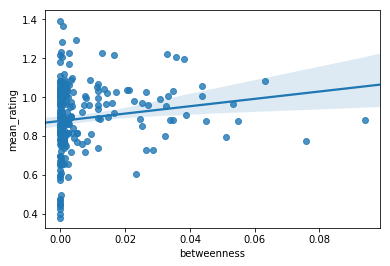

In [9]:
sns.regplot(x="betweenness", y="mean_rating", data=df);

In [10]:
test = scipy.stats.ttest_rel(df["betweenness"], df["mean_rating"])
print(test[1])
print("P-Value Betweenness x Mean_Rating: ", np.around(test[1],decimals=20))

1.73931605734e-172
P-Value Betweenness x Mean_Rating:  0.0


In [11]:
test = scipy.stats.ttest_rel(df["closeness"], df["mean_rating"])
print(test[1])
print("P-Value Closeness x Mean_Rating: ", np.around(test[1],decimals=20))

1.5627943944e-150
P-Value Closeness x Mean_Rating:  0.0
